# Homework 3: Reinforcement Learning
### Marco Giunta
----
**Abstract:** The reinforcement learning problem of learning how to play some simple games is tackled using a simple Deep Q-learning architecture.

# Introduction
*Reinforcement learning* is a machine learning framework in which an agent learns about an environment by direct interaction with the environment itself. In particular the agent receives the current state of the environment, performs some action, then receives a reward and the new state; the purpose of training is to find a way to maximize the reward. To be more specific the goal of the agent is to find the sequence of actions which will maximize the total discounted cumulative reward
\begin{equation}
  G_t = \sum_{k=0}^{+\infty}\gamma^k r_{t+k}
\end{equation}
$\gamma$ is the discount factor, i.e. a number in $[0,1]$ which quantifies whether the agent should prioritize short term gains ($\gamma \ll 1$) or long term ones ($\gamma\approx 1$).

In Q-learning the agent uses a function $Q_\pi(s,a)$ which computes the expected cumulative reward that will be obtained if the agent performs action $a$ when presented with state $s$. Given the current state the agent computes the value of the Q function for all possible actions, then decides which one to perform according to a fixed policy $\pi$. 

The optimal policy is by definition the one which maximizes the expected return:
\begin{equation}
  Q_{\text{opt}}(s,a) = \max_\pi Q(s,a)
\end{equation}
By substituting back in the definition of Q one finds the Bellman equation:
\begin{equation}
  Q_{\text{opt}}(s,a) = E_{s'}[r+\gamma\max_{a'} Q_{\text{opt}}(s',a')|s,a]
\end{equation}
The purpose of deep Q learning is to learn (an approximation of) this optimal Q function, which is computed using a neural network; this works because the previous equation can be turned into a loss function, as will be explained below.

# Cartpole
## Introduction
In the first part of the assignment we learn how to play `CartPolev1`, a simple OpenAI gym environment whose goal is to vertically balance a pole attached to a moving cart. In particular the agent controls the 2D cart by applying a fixed horizontal impulse to it every frame (either to the right or to the left, so that the action space dimension is 2); the agent receives information about the enviroment by the means of a 4-tuple, containing the current linear position/velocity of the cart and the angular position/velocity of the pole.
## Methods
To return the Q values associated to every possible action given a particular state we use the same simple NN used in Lab7, which consist of a single linear layer with 128 neurons + a `Tanh` activation. During training we actually use two copies of the network: the first is called the policy network, and is updated every frame, whereas the second one is called the target network and is updated every $N$ frames (with $N$ a model hyperparameter). This is useful to stabilize learning and to ensure the loss derived by the Bellman equation has the simple form:
\begin{equation}
  L(P(s,a), r+\gamma\max_{a'} T(s',a'))
\end{equation}
where $P(...)$ and $T(...)$ are the outputs of the two networks. As the $L$ function to be minimized we use the Huben loss, i.e. pytorch's `SmoothL1Loss`, which is an L1 loss for errors over 1, an L2 loss for error less than 1, and is differentiable even in the region where its behaviour changes.

To make training more effective a number of extra strategies are used:
- Replay memory: states belonging to the same episode (i.e. same game) are highly correlated, of course. This means the network risks specializing on specific games instead of learning the general way to beat the game; for this reason the batches used during training aren't simply the most recent ones, but rather are randomly sampled from a replay memory buffer. This ensures that batches often are far in time, hence significantly decreasing average batch correlation.
- Exploration profile: In order to ensure our network doesn't "get stuck" in a suboptimal way to play the game we need to make sure the agent explores a large enough portion of the action and state spaces. For this reason at the beginning of the training (when it's unlikely that the network has already found a decent way to play the game) we incentivize it to sometimes take random actions, with the hope that this may lead to serendipituous discoveries. This means temporarily abandoning the optimal policy of maximizing Q is sometimes needed; in particular we consider two simple alternative policies. The $\varepsilon$-greedy policy consists in performing a random action at any frame with probability $\varepsilon$, and the best action otherwise; the softmax policy instead consists on sampling actions from a softmax distribution with temperature $T$ defined on the Q values of the possible actions. One typically starts with high values of $\varepsilon$/$T$ which are then decreased over time (as a means of decreasing exploration) using some predefined scheme - which is our case will be an exponential decay. Notice that for simplicity in this notebook only the softmax policy is actually used.
- Gradient clipping: during training gradient norms are clipped to a max. of 2, to decrease the risk that the model will forget a good learned solution.

As our optimizer we use SGD with no momentum, since in order to play the game we may need to be able to rapidly adapt to different situations - hence a more volatile gradient can actually benefit convergence, in this case.

Finally notice that a small random search is performed; we perform 10 trials by selecting at random with uniform probability the following hyperparameters: $\gamma = 0.9, 0.91, 0.92, \dots, 0.99$, initial learning rate (10 values in the logspace between -3 and -1), initial temperature (a random integer between 3 and 6), when to perform target network update (every 5, 10, 15, 20 or 25 epochs) and batch size (32, 64, 128, 256).

We also remark that $-|x_C|$ is added to the reward to penalize the network if the cart is too far from the scene center, as this can improve convergence speed.

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from collections import deque
from tqdm import tqdm
import os
import random

In [2]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen = capacity) # Define a queue with maxlen "capacity"
    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples
    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [3]:
class DQN(nn.Module):
    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(state_space_dim, 128), nn.Tanh(), nn.Linear(128, action_space_dim))

    def forward(self, x):
        return self.linear(x)

In [4]:
net = DQN(state_space_dim = 4, action_space_dim = 2) # example network
net

DQN(
  (linear): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [5]:
def choose_action_epsilon_greedy(net, state, epsilon): 
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype = torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [6]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.21660617  0.22998768]


In [7]:
def choose_action_softmax(net, state, temperature):
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim = 0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [8]:
# Test if it works as expected
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.21660617  0.22998768]


In [9]:
def softmax_exploration_profile(num_iterations = 1000, initial_value = 5):
    # We compute the exponential decay in such a way the shape of the exploration 
    # profile does not depend on the number of iterations
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
    exploration_profile = initial_value * (exp_decay**np.arange(num_iterations)) # np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])
    
    return exploration_profile

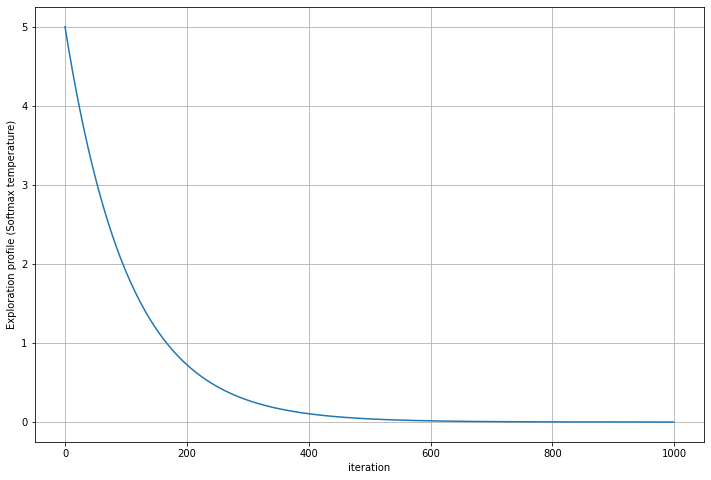

In [10]:
# Plot default softmax exploration profile
plt.figure(figsize = (12,8))
plt.plot(softmax_exploration_profile())
plt.grid()
plt.xlabel('iteration')
plt.ylabel('Exploration profile (Softmax temperature)');

In [11]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(1234) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


C:\Users\ma_gi\AppData\Local\Programs\Python\Python39\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Impossibile cambiare la modalità del thread dopo averla impostata
  warnings.warn(str(err))


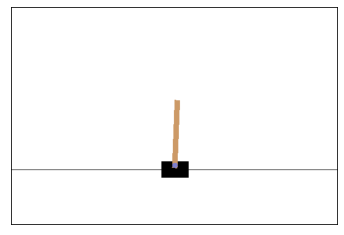

In [12]:
# example frame
env = gym.make('CartPole-v1') 
state = env.reset()
# Images are 600x400 pixels
s_shot = env.render(mode='rgb_array')
s_shot = np.ascontiguousarray(s_shot, dtype = np.float32)/255.
env.close()
plt.imshow(s_shot)
plt.yticks([]);
plt.xticks([]);

In [13]:
# RANDOM AGENT
# we check if everything works by letting a completely random agent play the game.
render_random_agent = False

# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1234) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      if render_random_agent:
        env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

EPISODE 1 - FINAL SCORE: 30.0
EPISODE 2 - FINAL SCORE: 13.0
EPISODE 3 - FINAL SCORE: 29.0
EPISODE 4 - FINAL SCORE: 13.0
EPISODE 5 - FINAL SCORE: 19.0
EPISODE 6 - FINAL SCORE: 15.0
EPISODE 7 - FINAL SCORE: 20.0
EPISODE 8 - FINAL SCORE: 10.0
EPISODE 9 - FINAL SCORE: 12.0
EPISODE 10 - FINAL SCORE: 30.0


In [14]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states  = torch.tensor([s[0] for s in batch], dtype = torch.float32)
    actions = torch.tensor([s[1] for s in batch], dtype = torch.int64)
    rewards = torch.tensor([s[3] for s in batch], dtype = torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype = torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype = torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [15]:
def training_loop(policy_net, target_net, replay_mem, exploration_profile, params, optimizer, loss_fn, min_samples_for_training = 1000, verbose = False):
    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(1234) # Set a random seed for the environment (reproducible results)

    training_score = []
    # We apply a (linear) penalty when the cart is far from center
    pos_weight = 1

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            reward = reward - pos_weight * np.abs(state[0]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, params['gamma'], optimizer, loss_fn, params['batch_size'])

            # Visually render the environment (disable to speed up the training)
            # if episode_num % 100 == 0:
            #     env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        training_score.append(score)
    env.close()
    
    return policy_net, training_score

In [16]:
def initialize_network(params, replay_memory_capacity = 10000, state_space_dim = 4, action_space_dim = 2):
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr = params['lr']) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [17]:
gamma = np.linspace(0.9, 0.99, 10)
lr = np.logspace(-3, -1, 10)
batch_size = np.array([32, 64, 128, 256])
target_update_step_values = np.arange(5, 25, 5, dtype = int)

def sample_hyperparameters(seed):
    np.random.seed(seed)
    initial_temp = np.random.randint(3, 7)
    params = {}
    params['initial_temp'] = initial_temp
    params['gamma'] = np.random.choice(gamma)
    params['lr'] = np.random.choice(lr)
    params['target_net_update_steps'] = np.random.choice(target_update_step_values)   
    params['batch_size'] = np.random.choice(batch_size)  
    params['bad_state_penalty'] = 0

    return params

In [18]:
hp = ['initial_temp', 'gamma', 'lr', 'target_net_update_steps', 'batch_size', 'bad_state_penalty', 'training_score']
def random_search(start_seed, end_seed):
    results_df = pd.DataFrame({s:[] for s in hp})
    for seed in range(start_seed, end_seed):
        params = sample_hyperparameters(seed)
        exploration_profile = exploration_profile = softmax_exploration_profile(initial_value = params['initial_temp'])
        
        replay_mem, policy_net, target_net, optimizer, loss_fn = initialize_network(params)
        policy_net, training_score = training_loop(policy_net, target_net, replay_mem, exploration_profile, params, optimizer, loss_fn, verbose = False)
        results_df = results_df.append({**params, 'training_score':training_score}, ignore_index=True)
    return results_df


In [19]:
if os.path.exists('random_search_results.csv'):
    df = pd.read_csv('random_search_results.csv').astype({'initial_temp':int, 'target_net_update_steps':int, 'batch_size':int}).drop('training_score', axis = 1)
    print('Results:')
    display(df)
else:
    df = random_search(0, 10)
    df.to_csv('random_search_results.csv', index = False)
    for i in range(10):
        np.savetxt(f'./random_search_histories/th_{i}.csv', df.training_score[i])
print('Best:')
df.nlargest(1, 'final_training_score')

Results:


,initial_temp,gamma,lr,target_net_update_steps,batch_size,bad_state_penalty,final_training_score
0,3,0.95,0.001000,20,256,0.0,50
1,4,0.98,0.100000,20,64,0.0,175
2,3,0.98,0.021544,20,128,0.0,19
3,5,0.98,0.100000,20,32,0.0,92
4,5,0.97,0.012915,10,32,0.0,45
5,6,0.96,0.021544,5,64,0.0,500
6,5,0.99,0.004642,5,128,0.0,10
7,6,0.94,0.100000,15,256,0.0,145
8,6,0.94,0.001668,10,64,0.0,47
9,5,0.95,0.021544,5,256,0.0,128


Best:


,initial_temp,gamma,lr,target_net_update_steps,batch_size,bad_state_penalty,final_training_score
5,6,0.96,0.021544,5,64,0.0,500


In [20]:
def train_single_model(seed):
    params = sample_hyperparameters(seed)
    exploration_profile = softmax_exploration_profile(initial_value = params['initial_temp'])
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize_network(params)
    policy_net, training_score = training_loop(policy_net, target_net, replay_mem, exploration_profile, params, optimizer, loss_fn, verbose = False)
    return policy_net, training_score

In [21]:
# policy_net_best, training_score_best = train_single_model(5)
# torch.save(policy_net_best.state_dict(), 'cartpole_best.pth')
# np.savetxt('cartpole_best_th.csv', training_score_best)
r, policy_net_best, t, o, l = initialize_network(sample_hyperparameters(5))
policy_net_best.load_state_dict(torch.load('cartpole_best.pth'))
training_score_best = np.loadtxt('cartpole_best_th.csv')

## Results
The best hyperparameters found are shown above, while the learning curve is shown below.

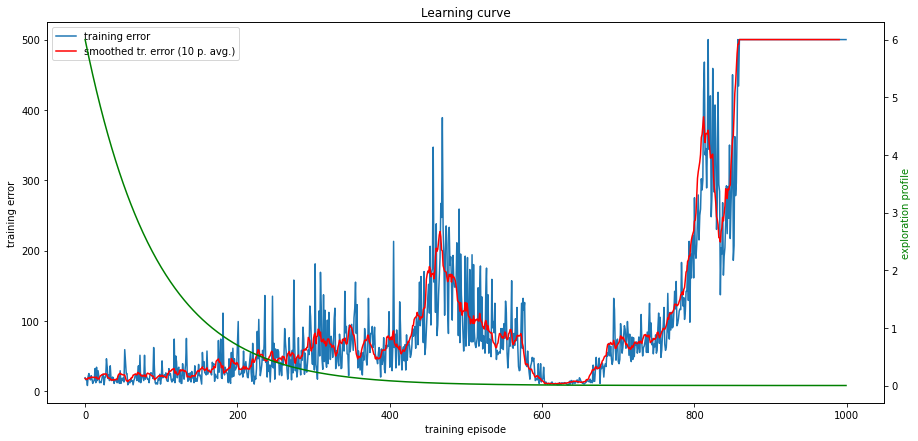

In [22]:
def plot_learning_curve(tr, initial_temp = 6, smooth: int = 10, figsize: tuple = (15, 7)):
    x = np.arange(len(tr))
    if smooth is not None:
        tr_s = np.convolve(tr, np.ones(smooth)/smooth, mode = 'valid')
        x_s  = np.arange(len(tr_s))
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot(x, tr, label = 'training error')
    if smooth is not None:
        ax.plot(x_s, tr_s, label = f'smoothed tr. error ({smooth} p. avg.)', c = 'r')
    ax.legend()
    ax.set_title('Learning curve')
    ax.set_xlabel('training episode')
    ax.set_ylabel('training error')

    ax2 = ax.twinx()
    ax2.plot(softmax_exploration_profile(initial_value = initial_temp), c = 'g')
    ax2.set_ylabel('exploration profile', color = 'g')

    return fig, ax
plot_learning_curve(training_score_best);

From this curve we notice that the agent is able to completely solve the game (as is confirmed in the code cell below), but that it takes a long amount of episodes to be able to do so. This is not surprising, since the performed random search was very small and the architecture very simple; it's possible that by extending these two (and maybe trying different optimizers, like e.g. Adam) convergence may be reached in a smaller amount of epochs. 

We also notice the impact of the softmax policy: around episode 600 the agent catastrophically forgets a good solution and takes a long time to recover it. This recovery time may be shortened by increasing the exploration profile in the later epochs, or by artificially decreasing the learning rate every time the network reaches a new high score (to make the agent less "volatile" once a good solution has been found). At any case we remark the impact of the exploration profile, in that if it decreases too quickly the agent may lose an important aid to quickly recover from losing a good solution.

In [23]:
# final test: we check whether our network is actually capable of consistently beating the game after training

# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1234) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net_best, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      # env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


As we can notice from the above cell after 1000 episodes our agent is able to beat the game every time, which means that even with a simple architecture and a limited random search learning was successful.

## Acrobot
We now perform the training of the same architecture over a new gym environment, called Acrobot-v1, where the goal of the game is moving a floppy robotic arm in such a way as to reach the upright position as quickly as possible. In particular the arm is divided in two segments using a joint in the middle, and the agent can either apply a fixed torque in the positive/negative direction or do nothing (so the action space is still discrete, but with dimension 3 and thus larger than before). The arm starts with a random angular velocity, and a reward of -1 is given to the agent for every frame where termination (i.e. upright position) has not been reached. If the arm reaches the upright position a reward of 0 is given and the game ends; if the total score reaches -500 the game is terminated too. Taking into account that it always takes some time to reach a termination condition (even with a successful learner) we can state that the overall score is a number between -500 and approximately -100.

This time no random search is performed since the game is more computationally demanding; instead we use the same best parameters found above.

In [24]:
### Create environment
env = gym.make('Acrobot-v1') # Initialize the Gym environment
env.seed(1234) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")
print(env.action_space)
print(env.observation_space)

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3
Discrete(3)
Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)


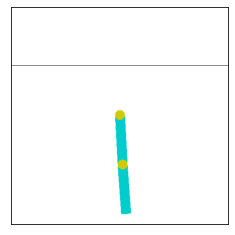

In [25]:
# example frame
env = gym.make('Acrobot-v1') 
state = env.reset()
# Images are 600x400 pixels
s_shot = env.render(mode='rgb_array')
s_shot = np.ascontiguousarray(s_shot, dtype = np.float32)/255.
env.close()
plt.imshow(s_shot)
plt.yticks([]);
plt.xticks([]);

In [26]:
# RANDOM AGENT to check if everything works
render_random_agent = False

# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(1234) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score > -500:
      # Choose a random action
      action = random.choice([0, 1, 2])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      if render_random_agent:
        env.render()
      # Update the final score 
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close() # always a terrible score. This makes sense since reaching termination without the minimum score requires reaching the upright position, which is almost impossible to do at random

EPISODE 1 - FINAL SCORE: -500.0
EPISODE 2 - FINAL SCORE: -500.0
EPISODE 3 - FINAL SCORE: -500.0
EPISODE 4 - FINAL SCORE: -500.0
EPISODE 5 - FINAL SCORE: -500.0
EPISODE 6 - FINAL SCORE: -500.0
EPISODE 7 - FINAL SCORE: -500.0
EPISODE 8 - FINAL SCORE: -500.0
EPISODE 9 - FINAL SCORE: -500.0
EPISODE 10 - FINAL SCORE: -500.0


In [27]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states  = torch.tensor([s[0] for s in batch], dtype = torch.float32, device = torch.device('cuda'))
    actions = torch.tensor([s[1] for s in batch], dtype = torch.int64, device = torch.device('cuda'))
    rewards = torch.tensor([s[3] for s in batch], dtype = torch.float32, device = torch.device('cuda'))

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype = torch.float32, device = torch.device('cuda')) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype = torch.bool, device = torch.device('cuda'))

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device = torch.device('cuda'))
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [28]:
# the training loop has to be overwritten since the reward is different in this game

def training_loop(policy_net, target_net, replay_mem, exploration_profile, params, optimizer, loss_fn, min_samples_for_training = 1000, verbose = False):
    # Initialize the Gym environment
    env = gym.make('Acrobot-v1') 
    env.seed(1234) # Set a random seed for the environment (reproducible results)

    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # Update the final score
            score += reward

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, params['gamma'], optimizer, loss_fn, params['batch_size'])

            # Visually render the environment (disable to speed up the training)
            # if episode_num % 100 == 0:
            #     env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        training_score.append(score)
    env.close()
    
    return policy_net, training_score

In [29]:
def initialize_network(params, replay_memory_capacity = 10000, state_space_dim = 6, action_space_dim = 3):
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr = params['lr']) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [30]:
hp = ['initial_temp', 'gamma', 'lr', 'target_net_update_steps', 'batch_size', 'bad_state_penalty', 'training_score']
def random_search(start_seed, end_seed):
    results_df = pd.DataFrame({s:[] for s in hp})
    for seed in range(start_seed, end_seed):
        params = sample_hyperparameters(seed)
        exploration_profile = exploration_profile = softmax_exploration_profile(initial_value = params['initial_temp'], num_iterations = 500)
        
        replay_mem, policy_net, target_net, optimizer, loss_fn = initialize_network(params)
        policy_net.to(torch.device('cuda'))
        target_net.to(torch.device('cuda'))
        
        policy_net, training_score = training_loop(policy_net, target_net, replay_mem, exploration_profile, params, optimizer, loss_fn, verbose = False)
        results_df = results_df.append({**params, 'final_training_score':training_score[-1]}, ignore_index = True)
        torch.save(policy_net.state_dict(), f'./random_search_2_models/model_{seed}.pth')
        np.savetxt(f'./random_search_2_models/th_{seed}.csv', training_score)
    return results_df


In [31]:
if os.path.exists('random_search_results_2.csv'):
    df = pd.read_csv('random_search_results_2.csv').astype({'initial_temp':int, 'target_net_update_steps':int, 'batch_size':int})
    print('Results:')
    display(df)
else:
    df = random_search(5, 6)
    df.to_csv('random_search_results_2.csv', index = False)
# print('Best:')
# df.nlargest(1, 'final_training_score')

Results:


,initial_temp,gamma,lr,target_net_update_steps,batch_size,bad_state_penalty,training_score,final_training_score
0,6,0.96,0.021544,5,64,0.0,NaN,-132.0


In [32]:
r, policy_net_best, t, o, l = initialize_network(sample_hyperparameters(5))
policy_net_best = policy_net_best#.cuda()
policy_net_best.load_state_dict(torch.load('./random_search_2_models/model_5.pth'))
training_score_best = np.loadtxt('./random_search_2_models/th_5.csv')

## Results

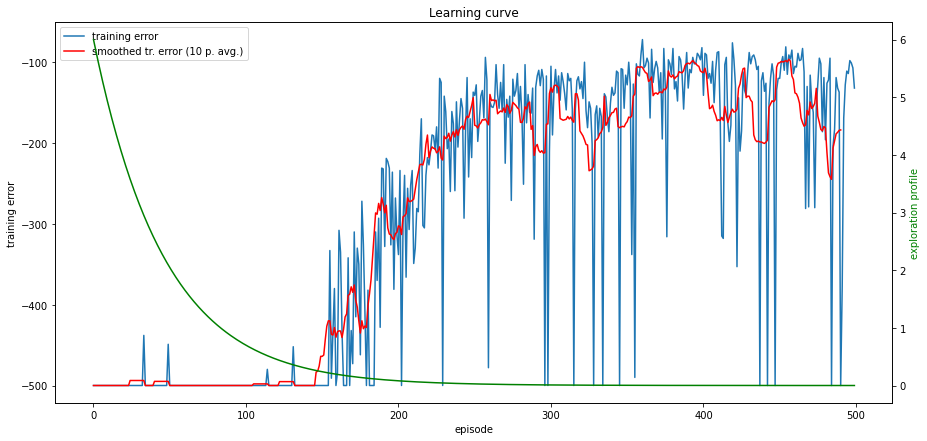

In [33]:
def plot_learning_curve(tr, initial_temp = 6, smooth: int = 10, figsize: tuple = (15, 7)):
    x = np.arange(len(tr))
    if smooth is not None:
        tr_s = np.convolve(tr, np.ones(smooth)/smooth, mode = 'valid')
        x_s  = np.arange(len(tr_s))
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot(x, tr, label = 'training error')
    if smooth is not None:
        ax.plot(x_s, tr_s, label = f'smoothed tr. error ({smooth} p. avg.)', c = 'r')
    ax.legend()
    ax.set_title('Learning curve')
    ax.set_xlabel('episode')
    ax.set_ylabel('training error')

    ax2 = ax.twinx()
    ax2.plot(softmax_exploration_profile(initial_value = initial_temp, num_iterations = 500), c = 'g')
    ax2.set_ylabel('exploration profile', color = 'g')

    return fig, ax
plot_learning_curve(training_score_best);

In [34]:
# final test

# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(1234) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net_best, state, temperature = 0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      # env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -266.0
EPISODE 2 - FINAL SCORE: -108.0
EPISODE 3 - FINAL SCORE: -113.0
EPISODE 4 - FINAL SCORE: -157.0
EPISODE 5 - FINAL SCORE: -110.0
EPISODE 6 - FINAL SCORE: -95.0
EPISODE 7 - FINAL SCORE: -86.0
EPISODE 8 - FINAL SCORE: -131.0
EPISODE 9 - FINAL SCORE: -98.0
EPISODE 10 - FINAL SCORE: -128.0


As we can see from the previous results the network is able to quickly learn how to beat the game, but it struggles with consistency in the sense that it's not always able to reach the maximum (-100). Still we notice that it's never very far from it, so considering the limits of our approach (small random search, simple architecture and optimizer, etc.) we can consider learning successful once again.